In [21]:
import os
import numpy as np
from math import exp, log
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import random
import gzip
from matplotlib import pyplot
import matplotlib as mpl
import time

%matplotlib inline

data_file_name = {
    'train_image':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_image':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz'
}

dir_data_file = './data'

train_num = 60000
test_num = 10000
image_dimension = (28, 28)
image_size = 784



In [5]:
def LoadLabel(file_name):
    # file_name의 Binary 파일을 읽어서 numpy.ndarray 를 Return 한다.
    file_path = dir_data_file + "/" + file_name
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    rtval = data
    print(file_name + " file loaded")
    return rtval

def LoadImage(file_name):
    # file_name의 Binary 파일을 읽어서 numpy.ndarray 를 Return 한다.
    file_path = dir_data_file + "/" + file_name   
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    rtval = data.reshape(-1, image_size)
    print(file_name + " file loaded")
    return rtval

def DictoNumpy():
    ## Dictionary data-type으로 
    dic_data = {}
    print(type(dic_data))
    dic_data['train_image'] =  LoadImage(data_file_name['train_image'])
    dic_data['train_label'] = LoadLabel(data_file_name['train_label'])    
    dic_data['test_image'] = LoadImage(data_file_name['test_image'])
    dic_data['test_label'] = LoadLabel(data_file_name['test_label'])
    
    return dic_data

def NormalizeData(dic_data):
    dic_data['train_image'] = dic_data['train_image']/255
    dic_data['test_image'] = dic_data['test_image']/255
    return dic_data

def ImageDisplay(list_data):
    ## List형의 Pixcel 정보를 받아서 이미지로 보여준다.
    fig = pyplot.figure()
    axis = fig.add_subplot(1,1,1)
    plot_img = axis.imshow(list_data, cmap=mpl.cm.Greys)
    plot_img.set_interpolation('none')
#    ax.xaxis.set_ticks_position('top')
#    ax.yaxis.set_ticks_position('left')
    pyplot.show()

def ascii_show(image):
    for y in image:
        row = ""
        for x  in y:
            row += '{0: <4}'.format(x)
        print (row)
        
        
def MakeNetwork(sizes):
    num_layers = len(sizes)-1
    
    biases = [np.random.randn(y, 1) for y in sizes[1:]]
    weights = [np.random.randn(y, x) 
                for x, y in zip(sizes[:-1], sizes[1:])]
    
    return num_layers, biases, weights

<class 'dict'>
train-images-idx3-ubyte.gz file loaded
train-labels-idx1-ubyte.gz file loaded
t10k-images-idx3-ubyte.gz file loaded
t10k-labels-idx1-ubyte.gz file loaded
<class 'numpy.ndarray'>
5


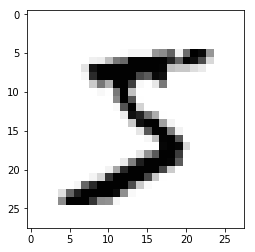

3


In [3]:
net_sizes = [784,100,50,10]
num_layers, biases, weights = MakeNetwork(net_sizes)
save_init_random_b = biases
save_init_random_w = weights
dic_data = DictoNumpy()
dic_data = NormalizeData(dic_data)

print (type(dic_data['train_image'][0]))
print (dic_data['train_label'][0])
ImageDisplay (dic_data['train_image'][0].reshape(28,28))
print (num_layers)

In [6]:
def Sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def SigmoidPrime(x):
    return Sigmoid(x)*(1-Sigmoid(x))

def SoftMax(x):
    exp = np.exp(x-np.max(x))
    return exp / np.sum(exp)

def OneHotLabel(x):
    onehot = np.zeros((x.size, 10))
    for i, row in enumerate(onehot):
        row[x[i]] = 1
    return onehot 

def ForwardPropagation(x, w, b):
    a = np.dot(w, x) + b
    return a # Sigmoid(a)

def MeanSqrError(y, t):
    return 0.5*np.sum((y-t)**2)

def CrossEntropy ( y, t ):
    delta = 1e-7
    return -np.sum(t * np.log(y+delta))



In [7]:
def PredictOutput(x, weights, biases, num_layers, net_sizes):
    
    last_layer = num_layers-1
    out_list = []
    a = x
    for i in range(last_layer):
        y = ForwardPropagation(a, weights[i],np.reshape(biases[i],(net_sizes[i+1],))) # np.transpose(biases[i]))
                               #np.reshape(biases[i],(net_sizes[i+1],1)) )# biases[i].resape(len(net_sizes[i+1]),))
        a = Sigmoid(y)
        out_list.append(y)
    
    predicted_output = ForwardPropagation(a,weights[last_layer], np.reshape(biases[last_layer],(net_sizes[-1],))) #np.transpose(biases[last_layer]))
    
    out_list.append(predicted_output)
    
                                          #np.reshape(biases[i],(net_sizes[-1],1))) # biases[last_layer].reshape(len(net_sizes[-1]),))
    return predicted_output, out_list

def BackPropagation(x, w, b, predicted_output, out_list, d, num_layers, net_sizes):
    delta_b = []
    delta_w = []
    
    ## Last_Layer Derivative 
    ## Example net_sizes = [ 784, 100, 50, 10 ]
    ## out_list = [ y1, y2, y3  ]
    ## After Activation :: a = Sigmoid(out_list)
    ## a = [ a1, a2, a3=y3 ]
    
    d_b_L = (out_list[-1]-d).reshape(len(d),1)
    d_w_L = np.dot(d_b_L, Sigmoid(out_list[-2].reshape(1,len(out_list[-2]))))
    
    delta_b.append(d_b_L)
    delta_w.append(d_w_L)
    
    d_b_p = d_b_L
    
    for i in range(num_layers-1):
        idx = num_layers-2-i
        d_b = []
        d_w = []
        
        #print (idx, net_sizes[idx+1],net_sizes[idx+2])
        
        #d_b = np.dot(w[idx].reshape(net_sizes[idx+1],net_sizes[idx+2]), d_b)*SigmoidPrime(out_list[idx].reshape(net_sizes[idx+1],1))
        d_b = np.dot(w[idx+1].transpose(), d_b_p)*SigmoidPrime(out_list[idx].reshape(net_sizes[idx+1],1))
        
        #print (len(d_b))
        
        if idx == 0:
            d_w = np.dot(d_b, x.reshape(1,len(x)))
        else:
            d_w = np.dot(d_b, Sigmoid(out_list[idx-1].reshape(1,len(out_list[idx-1]))))
        
        delta_b.append(d_b)
        delta_w.append(d_w)
        
        d_b_p = d_b
    
    delta_b.reverse()
    delta_w.reverse()
    
    return delta_b, delta_w




In [8]:
dic_data = DictoNumpy()
dic_data = NormalizeData(dic_data)

<class 'dict'>
train-images-idx3-ubyte.gz file loaded
train-labels-idx1-ubyte.gz file loaded
t10k-images-idx3-ubyte.gz file loaded
t10k-labels-idx1-ubyte.gz file loaded


In [37]:
net_sizes = [784,100,50,10]
#net_sizes = [784,30,10]
num_layers, biases, weights = MakeNetwork(net_sizes)
save_init_random_b = biases
save_init_random_w = weights

print (biases[-1])

[[ 0.04329603]
 [-0.38393085]
 [-0.10002016]
 [-0.76903506]
 [ 0.22726196]
 [-0.48729225]
 [ 0.02696118]
 [ 0.39549338]
 [ 0.9097608 ]
 [ 2.00604309]]


In [38]:
## Batch 처리
batch_size = 500
repeat_gradient = 30
learning_rate = 0.1

input_data = dic_data['train_image']
one_hot_output = OneHotLabel(dic_data['train_label'])

test_data = dic_data['test_image']
one_hot_output_test = OneHotLabel(dic_data['test_label'])

train_err_list = []
test_err_list = []

print ('learning rate : ', learning_rate, )
print ('Network Size : ', net_sizes)
print ('Number of Layers : ', num_layers)
print ('Condition : Sigmoid, One-Hot, Identity, MSE')
print ('--------------------------------------------------------')

for k in range(int(train_num/batch_size)): # sample selection

    epoch_error = []
    start_t = time.time()
    for j in range(repeat_gradient): # repeat gradient
        
        prediction_error_batch = []
        prediction_error = 0
        
        for i in range(batch_size):
            idx = i+k*batch_size
            
            predicted_output, out_list = PredictOutput(input_data[idx], weights, biases, num_layers, net_sizes)
            
            d = np.array(one_hot_output[idx])
            
            #print (predicted_output[:3], d[:3])
            
            error = MeanSqrError(np.array(predicted_output), d)
            
            delta_b, delta_w = BackPropagation(input_data[idx], weights, biases, predicted_output, out_list, d, num_layers, net_sizes)

            if np.argmax(predicted_output) == np.argmax(d):
                prediction_error = prediction_error+1

            prediction_error_batch.append(error)
        
            for m in range(num_layers):
                weights[m] = weights[m]-learning_rate*delta_w[m] # (sum(dl_w1)/batch_size)
                biases[m] = biases[m]-learning_rate*delta_b[m] # (sum(dl_b1)/batch_size)
        
        #weights[1] = weights[1]-learning_rate*(sum(dl_w2)/batch_size)
        #biases[1] = biases[1]-learning_rate*(sum(dl_b2)/batch_size)
    
    test_error = 0
    
    for j in range(test_num):
        idx = j

#        a2 = PredictOutput(test_data[idx],weights,biases )
        test_output, out2 = PredictOutput(test_data[idx], weights, biases, num_layers, net_sizes)
        d = np.array(one_hot_output_test[idx])
        
        if np.argmax(test_output) == np.argmax(d):
            test_error = test_error+1
    
    end_t = time.time() - start_t
    percent_tr_er = 100*prediction_error/batch_size
    percent_ts_er = 100*test_error/test_num

    print ('Epoch :', k+1, (k+1)*batch_size, "rt:%.2fs"%end_t, "train-err:%.1f"%percent_tr_er,"%","test-err:%.1f"%percent_ts_er, "%")
    train_err_list.append(prediction_error/batch_size)
    test_err_list.append(test_error/test_num)


learning rate :  0.1
Network Size :  [784, 100, 50, 10]
Number of Layers :  3
Condition : Sigmoid, One-Hot, Identity, MSE
--------------------------------------------------------
Epoch : 1 500 rt:7.38s train-err:72.2 % test-err:36.4 %
Epoch : 2 1000 rt:11.53s train-err:91.0 % test-err:68.4 %
Epoch : 3 1500 rt:10.81s train-err:90.8 % test-err:75.1 %
Epoch : 4 2000 rt:10.93s train-err:93.8 % test-err:78.0 %
Epoch : 5 2500 rt:7.28s train-err:97.4 % test-err:79.4 %
Epoch : 6 3000 rt:7.43s train-err:94.8 % test-err:80.7 %
Epoch : 7 3500 rt:7.26s train-err:95.6 % test-err:80.5 %
Epoch : 8 4000 rt:6.98s train-err:95.8 % test-err:82.0 %
Epoch : 9 4500 rt:6.98s train-err:94.0 % test-err:83.3 %
Epoch : 10 5000 rt:7.04s train-err:95.2 % test-err:83.6 %
Epoch : 11 5500 rt:7.10s train-err:94.0 % test-err:84.4 %


KeyboardInterrupt: 

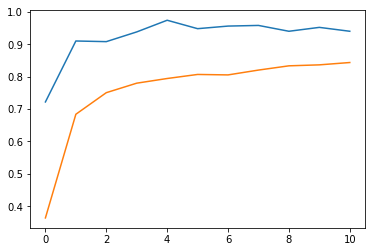

In [39]:
plt.figure()
plt.plot(train_err_list)
plt.plot(test_err_list)